In [2]:
import numpy as np
import pandas as pd
import spacy
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from clean_function import clean
import re
from transformers import BertTokenizer, BertModel
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='transformers.utils.generic')
import time


import torch



c:\Users\yonas\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df=pd.read_csv("data1.csv")

In [4]:
df.head()


,Reviewer_Name,Reviewer_Rating,Review_Title,Review_Text,Place_of_Review,Date_of_Review,Up_Votes,Down_Votes
0,Sumit Kumar,5.0,Wonderful,I think In this price category it's best dosa ...,"Certified Buyer, Lakhisarai",Sumit Kumar,211,39
1,BHARAT GALAGALI,5.0,Mind-blowing purchase,perfect tawa for Dosa..READ MORE,"Certified Buyer, Hunsur",BHARAT GALAGALI,107,17
2,Paramjeet Singh,5.0,Awesome,Excellent tawa. Made Paneer Tikka on first day...,"Certified Buyer, Rampura Phul",Paramjeet Singh,59,8
3,Virendra Kumar,5.0,Great product,Nice 🙂 productREAD MORE,"Certified Buyer, Chengalpattu District",Virendra Kumar,77,12
4,jyoti solanki,5.0,Best in the market!,Delivery man is also good....READ MORE,"Certified Buyer, Mumbai",jyoti solanki,53,7


In [5]:
df.drop(columns=["Reviewer_Name","Review_Title","Place_of_Review","Date_of_Review","Up_Votes","Down_Votes"], inplace=True)

In [6]:
df.head()

,Reviewer_Rating,Review_Text
0,5.0,I think In this price category it's best dosa ...
1,5.0,perfect tawa for Dosa..READ MORE
2,5.0,Excellent tawa. Made Paneer Tikka on first day...
3,5.0,Nice 🙂 productREAD MORE
4,5.0,Delivery man is also good....READ MORE


In [7]:
def classify_rating(rating):
    if rating > 3:
        return 1  # Positive
    elif rating == 3:
        return 2  # Neutral
    else:
        return 3  # Negative
df['Reviewer_Rating'] = df['Reviewer_Rating'].apply(classify_rating)

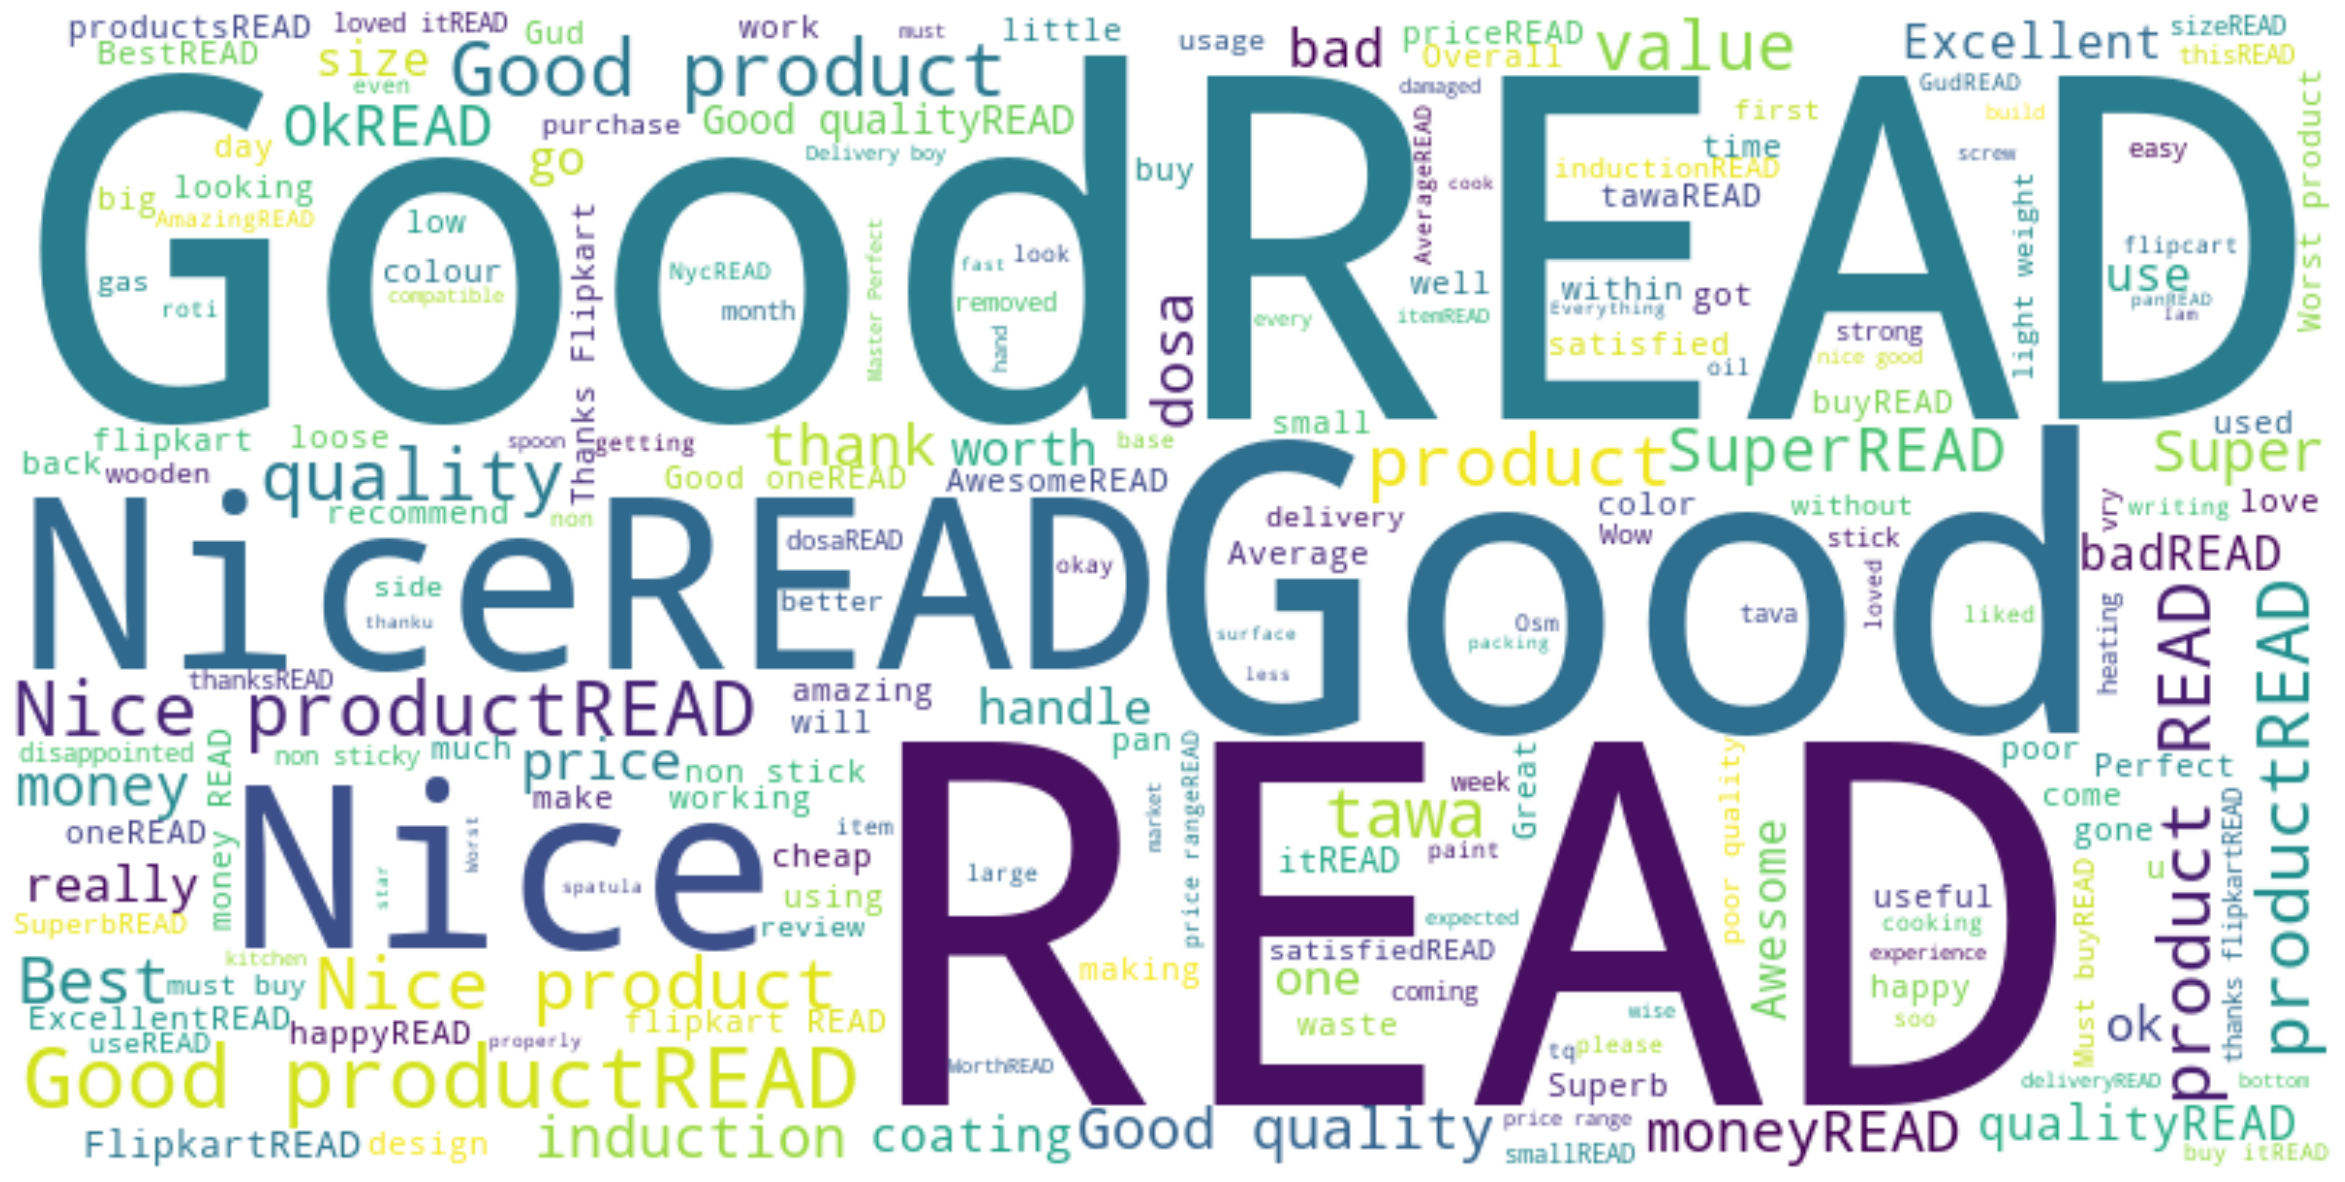

In [8]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# Create a WordCloud object
text = " ".join(review for review in df["Review_Text"])
wc = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the WordCloud
plt.figure(figsize=(30, 20))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [9]:
x=df.Review_Text
y=df.Reviewer_Rating
print(x.shape ,y.shape)

(2531,) (2531,)


In [10]:
# Step 2: Split the data into train and test

from sklearn.model_selection import train_test_split

# split X and y into training and testing sets.
# By default, it splits 75% training and 25% test
# random_state=1 for reproducibility

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1898,) (1898,)
(633,) (633,)


In [39]:
nlp = spacy.load("en_core_web_sm")
# Initialize spell checker


In [11]:
# def clean(doc):
#     # Remove punctuation
#     doc = re.sub(r'[^\w\s]', '', doc)
#     # Convert to lowercase
#     doc = doc.lower()
#     # Tokenize and lemmatize
#     doc = nlp(doc)
#     lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
#     # Join tokens back into a string
#     return " ".join(lemmatized_tokens)

In [11]:
df["Review_Text"].apply(clean)

0       think price category good dosa tawa try turn g...
1                                   perfect tawa dosaread
2                     excellent tawa paneer tikka dayread
3                                      nice   productread
4                                   delivery man goodread
                              ...                        
2526                                  handel includedread
2527                                             niceread
2528                  good price handle cheap durebleread
2529                  tawa ok handle regidpoor handleread
2530                                             niceread
Name: Review_Text, Length: 2531, dtype: object

In [ ]:
# def clean(doc):
#     doc=re.sub(r'[^\w\s]', '', doc)
#     doc=doc.lower()
#     doc = nlp(doc)
#     tokens=[token.text for token in doc]
#     # Lemmatize
#      # Filter out stop words and perform lemmatization
#     doc1 = nlp(tokens)
#     lemmatized_tokens=[token.lemma_ for token in doc1]
#     stopword_filterd=[token.text for token in lemmatized_tokens if not token.is_stop]


#     return " ".join(stopword_filterd)

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate a vectorizer
vect = CountVectorizer(preprocessor=clean)

# use it to extract features from training data
%time X_train_dtm = vect.fit_transform(X_train)

print(X_train_dtm.shape)

CPU times: total: 12 s
Wall time: 12.7 s
(1898, 1063)


In [13]:
# Step 4: Data Preprocessing on test data (X_test)

# transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)

print(X_test_dtm.shape)

(633, 1063)


In [14]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [15]:
import warnings
from sklearn.naive_bayes import MultinomialNB

warnings.filterwarnings('ignore')

In [20]:
pipe = Pipeline(
    [
        ('vectorization', CountVectorizer()),
        ('nb', MultinomialNB())
    ]
)

MAX_FEATURES = [1000, 1500, 2000]
ALPHA = [1, 10]

# Observe the Key Value Pair format
parameter_grid = [{'vectorization__preprocessor' : [clean],
                   'vectorization__max_features' : MAX_FEATURES,
                   'nb__alpha' : ALPHA}]

# Using f1_macro for multiclass classification
clf = GridSearchCV(
    estimator=pipe,
    param_grid=parameter_grid,
    scoring='f1_macro',
    cv=5,
    return_train_score=True,
    verbose=1
)

%time clf.fit(X_train, y_train)

print("Best estimator found on train set")
print(clf.best_estimator_)
print()

print('Score on Test Data: ', clf.score(X_test, y_test))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


KeyboardInterrupt: 

Best estimator found on train set


AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [ ]:
# pipe_1 = Pipeline(
#     [
#         ('vectorizer', CountVectorizer(preprocessor=clean)),  # Add text vectorizer
#         ('scaler', StandardScaler(with_mean=False)),  # Scaling after vectorization
#         ('classifier', KNeighborsClassifier())
#     ]
# )


# N_NEIGHBORS = [i for i in range(3, 10, 2)]
# P = [1, 2, 3]

# # Observe the Key Value Pair format

# parameter_grid_1 = [
#     {
#         'scaler': [StandardScaler(with_mean=False), MinMaxScaler()],
#         'classifier__n_neighbors': N_NEIGHBORS,
#         'classifier__p': P
#     }
# ]

# clf = GridSearchCV(
#     estimator=pipe_1,
#     param_grid=parameter_grid_1,
#     scoring='accuracy',
#     cv=5,
#     return_train_score=True,
#     verbose=1
# )

# %time clf.fit(X_train, y_train)

NameError: name 'Pipeline' is not defined

from joblib import Memory
import os
# Directory for caching
cache_dir = './cache_dir'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

# Initialize memory object
memory = Memory(location=cache_dir, verbose=0)

# Define your pipelines with caching
pipelines = {
    'knn': Pipeline([
        ('vectorizer', CountVectorizer(preprocessor=clean)),
        ('scaler', StandardScaler(with_mean=False)),
        ('classifier', KNeighborsClassifier())
    ], memory=memory),
    'svc': Pipeline([
        ('vectorizer', CountVectorizer(preprocessor=clean)),
        ('scaler', StandardScaler(with_mean=False)),
        ('classifier', SVC())
    ], memory=memory),
    'logistic_regression': Pipeline([
        ('vectorizer', CountVectorizer(preprocessor=clean)),
        ('scaler', StandardScaler(with_mean=False)),
        ('classifier', LogisticRegression())
    ], memory=memory),
    'random_forest': Pipeline([
        ('vectorizer', CountVectorizer(preprocessor=clean)),
        ('scaler', StandardScaler(with_mean=False)),
        ('classifier', RandomForestClassifier())
    ], memory=memory),
    'decision_tree': Pipeline([
        ('vectorizer', CountVectorizer(preprocessor=clean)),
        ('scaler', StandardScaler(with_mean=False)),
        ('classifier', DecisionTreeClassifier())
    ], memory=memory),
    'naive_bayes': Pipeline([
        ('vectorizer', CountVectorizer(preprocessor=clean)),
        ('scaler', StandardScaler(with_mean=False)),
        ('classifier', GaussianNB())
    ], memory=memory)
}

# Define parameter grids
MAX_FEATURES = [1000, 1500, 2000]

param_grids = {
    'knn': [
        {
            'vectorizer__max_features': MAX_FEATURES,
            'scaler': [StandardScaler(with_mean=False), MinMaxScaler()],
            'classifier__n_neighbors': [i for i in range(3, 21, 2)],
            'classifier__p': [1, 2, 3]
        }
    ],
    'svc': [
        {
            'vectorizer__max_features': MAX_FEATURES,
            'scaler': [StandardScaler(with_mean=False), MinMaxScaler()],
            'classifier__kernel': ['rbf'],
            'classifier__C': [0.1, 0.01, 1, 10, 100]
        },
        {
            'vectorizer__max_features': MAX_FEATURES,
            'scaler': [StandardScaler(with_mean=False), MinMaxScaler()],
            'classifier__kernel': ['poly'],
            'classifier__degree': [2, 3, 4, 5],
            'classifier__C': [0.1, 0.01, 1, 10, 100]
        },
        {
            'vectorizer__max_features': MAX_FEATURES,
            'scaler': [StandardScaler(with_mean=False), MinMaxScaler()],
            'classifier__kernel': ['linear'],
            'classifier__C': [0.1, 0.01, 1, 10, 100]
        }
    ],
    'logistic_regression': [
        {
            'vectorizer__max_features': MAX_FEATURES,
            'scaler': [StandardScaler(with_mean=False), MinMaxScaler()],
            'classifier__C': [0.1, 1, 10],
            'classifier__penalty': ['l2']
        },
        {
            'vectorizer__max_features': MAX_FEATURES,
            'scaler': [StandardScaler(with_mean=False), MinMaxScaler()],
            'classifier__C': [0.1, 1, 10],
            'classifier__penalty': ['l1'],
            'classifier__solver': ['liblinear']
        },
        {
            'vectorizer__max_features': MAX_FEATURES,
            'scaler': [StandardScaler(with_mean=False), MinMaxScaler()],
            'classifier__C': [0.1, 1, 10],
            'classifier__penalty': ['elasticnet'],
            'classifier__l1_ratio': [0.4, 0.5, 0.6],
            'classifier__solver': ['saga']
        }
    ],
    'random_forest': [
        {
            'vectorizer__max_features': MAX_FEATURES,
            'scaler': [StandardScaler(with_mean=False), MinMaxScaler()],
            'classifier__n_estimators': [50, 100, 200]
        }
    ],
    'decision_tree': [
        {
            'vectorizer__max_features': MAX_FEATURES,
            'scaler': [StandardScaler(with_mean=False), MinMaxScaler()],
            'classifier__max_depth': [None, 5, 10]
        }
    ],
    'naive_bayes': [
        {
            'vectorizer__max_features': MAX_FEATURES,
            'scaler': [StandardScaler(with_mean=False), MinMaxScaler()]
        }
    ]
}

# Perform GridSearchCV for each algorithm
best_models = {}

for algo in pipelines.keys():
    print("*" * 10, algo, "*" * 10)
    grid_search = GridSearchCV(estimator=pipelines[algo],
                               param_grid=param_grids[algo],
                               cv=5,
                               scoring='accuracy',
                               return_train_score=True,
                               verbose=1
                              )

    try:
        %time grid_search.fit(X_train, y_train)
        best_models[algo] = grid_search.best_estimator_
        print('Best Score on Test Data: ', grid_search.score(X_test, y_test))
    except AttributeError as e:
        print(f"AttributeError during GridSearchCV fitting for {algo}: {e}")
    except Exception as e:
        print(f"Error during GridSearchCV fitting for {algo}: {e}")

# Checking the best models
print("Best models found:")
for algo, model in best_models.items():
    print(f"{algo}: {model}")

In [16]:
import joblib
from joblib import Memory

from functools import lru_cache

import os

In [17]:

%time X_train_clean = X_train.apply(lambda doc: clean(doc))

CPU times: total: 12.4 s
Wall time: 13.6 s


In [18]:
%time X_test_clean = X_test.apply(lambda doc: clean(doc))

CPU times: total: 4.16 s
Wall time: 4.63 s


In [19]:
# Define a memory object to cache intermediate results
cachedir = '.cache'
memory = Memory(location=cachedir, verbose=0)

In [20]:
print(X_train)

1621                             Value for moneyREAD MORE
2250                         It is super productREAD MORE
664                                    Not worthREAD MORE
1060    Good quality but they should been provided wit...
181                                    Very GoodREAD MORE
                              ...                        
960                        Thickness is not goodREAD MORE
905     Super good quality and good design thanks for ...
1096                                        GoodREAD MORE
235     Very poor quality lm very disappointed with th...
1061                                Good productREAD MORE
Name: Review_Text, Length: 1898, dtype: object


In [22]:


# Define your pipelines with caching
pipelines = {
    'knn': Pipeline([
        ('vectorizer', CountVectorizer(preprocessor=clean)),  # Add text vectorizer
        ('scaler', StandardScaler(with_mean=False)),  # Scaling after vectorization
        ('classifier', KNeighborsClassifier())
    ], memory=memory),
    'svc': Pipeline([
        ('vectorizer', CountVectorizer(preprocessor=clean)),  # Add text vectorizer
        ('scaler', StandardScaler(with_mean=False)),  # Scaling after vectorization
        ('classifier', SVC())
    ], memory=memory),
    'logistic_regression': Pipeline([
        ('vectorizer', CountVectorizer(preprocessor=clean)),  # Add text vectorizer
        ('scaler', StandardScaler(with_mean=False)),  # Scaling after vectorization
        ('classifier', LogisticRegression())
    ], memory=memory),
    'random_forest': Pipeline([
        ('vectorizer', CountVectorizer(preprocessor=clean)),  # Add text vectorizer
        ('scaler', StandardScaler(with_mean=False)),  # Scaling after vectorization
        ('classifier', RandomForestClassifier())
    ], memory=memory),
    'decision_tree': Pipeline([
        ('vectorizer', CountVectorizer(preprocessor=clean)),  # Add text vectorizer
        ('scaler', StandardScaler(with_mean=False)),  # Scaling after vectorization
        ('classifier', DecisionTreeClassifier())
    ], memory=memory),
    'naive_bayes': Pipeline([
        ('vectorizer', CountVectorizer(preprocessor=clean)),  # Add text vectorizer
        ('scaler', StandardScaler(with_mean=False)),  # Scaling after vectorization
        ('classifier', GaussianNB())
    ], memory=memory)
}


# Define parameter grids
MAX_FEATURES = [500, 1000]

param_grids = {
    'knn': [
        {
            'vectorizer__preprocessor' : [clean],
            'vectorizer__max_features': MAX_FEATURES,
            'scaler': [StandardScaler(with_mean=False), MinMaxScaler()],
            'classifier__n_neighbors': [i for i in range(3, 10, 2)],
            'classifier__p': [1, 2, 3]
        }
    ],
    'svc': [
        {
            'vectorizer__preprocessor' : [clean],
            'vectorizer__max_features': MAX_FEATURES,
            'scaler': [StandardScaler(with_mean=False), MinMaxScaler()],
            'classifier__kernel': ['rbf'],
            'classifier__C': [0.1, 1, 10, 100]
        },
        {
            'vectorizer__preprocessor' : [clean],
            'vectorizer__max_features': MAX_FEATURES,
            'scaler': [StandardScaler(with_mean=False), MinMaxScaler()],
            'classifier__kernel': ['poly'],
            'classifier__degree': [2, 4],
            'classifier__C': [0.1, 0.01, 1]
        },
        {
            'vectorizer__preprocessor' : [clean],
            'vectorizer__max_features': MAX_FEATURES,
            'scaler': [StandardScaler(with_mean=False), MinMaxScaler()],
            'classifier__kernel': ['linear'],
            'classifier__C': [0.1, 0.01, 1]
        }
    ],
    'logistic_regression': [
        {
            'vectorizer__preprocessor' : [clean],
            'vectorizer__max_features': MAX_FEATURES,
            'scaler': [StandardScaler(with_mean=False), MinMaxScaler()],
            'classifier__C': [0.1, 1, 10],
            'classifier__penalty': ['l2']
        },
        {
            'vectorizer__preprocessor' : [clean],
            'vectorizer__max_features': MAX_FEATURES,
            'scaler': [StandardScaler(with_mean=False), MinMaxScaler()],
            'classifier__C': [0.1, 1, 10],
            'classifier__penalty': ['l1'],
            'classifier__solver': ['liblinear']
        },
        {
            'vectorizer__preprocessor' : [clean],
            'vectorizer__max_features': MAX_FEATURES,
            'scaler': [StandardScaler(with_mean=False), MinMaxScaler()],
            'classifier__C': [0.1, 1, 10],
            'classifier__penalty': ['elasticnet'],
            'classifier__l1_ratio': [0.4, 0.5, 0.6],
            'classifier__solver': ['saga']
        }
    ],
    'random_forest': [
        {
            'vectorizer__preprocessor' : [clean],
            'vectorizer__max_features': MAX_FEATURES,
            'scaler': [StandardScaler(with_mean=False), MinMaxScaler()],
            'classifier__n_estimators': [50, 100, 200]
        }
    ],
    'decision_tree': [
        {
            'vectorizer__preprocessor' : [clean],
            'vectorizer__max_features': MAX_FEATURES,
            'scaler': [StandardScaler(with_mean=False), MinMaxScaler()],
            'classifier__max_depth': [None, 5, 10]
        }
    ],
    'naive_bayes': [
        {
            'vectorizer__preprocessor' : [clean],
            'vectorizer__max_features': MAX_FEATURES,
            'scaler': [StandardScaler(with_mean=False)]
        }
    ]
}

# Perform GridSearchCV for each algorithm
best_models = {}

for algo in pipelines.keys():
    print("*"*10, algo, "*"*10)
    grid_search = GridSearchCV(estimator=pipelines[algo], 
                               param_grid=param_grids[algo], 
                               cv=3, 
                               scoring='accuracy', 
                               return_train_score=True,
                               verbose=1,
                               n_jobs=-1
                              )
    
    grid_search.fit(X_train, y_train)
    
    %time best_models[algo] = grid_search.best_estimator_
    
    print('Score on Test Data: ', grid_search.score(X_test, y_test))

********** knn **********
Fitting 3 folds for each of 48 candidates, totalling 144 fits
CPU times: total: 0 ns
Wall time: 0 ns
Score on Test Data:  0.8120063191153238
********** svc **********
Fitting 3 folds for each of 52 candidates, totalling 156 fits
CPU times: total: 0 ns
Wall time: 0 ns
Score on Test Data:  0.8293838862559242
********** logistic_regression **********
Fitting 3 folds for each of 60 candidates, totalling 180 fits
CPU times: total: 0 ns
Wall time: 0 ns
Score on Test Data:  0.8420221169036335
********** random_forest **********
Fitting 3 folds for each of 12 candidates, totalling 36 fits
CPU times: total: 0 ns
Wall time: 0 ns
Score on Test Data:  0.8262243285939969
********** decision_tree **********
Fitting 3 folds for each of 12 candidates, totalling 36 fits
CPU times: total: 0 ns
Wall time: 0 ns
Score on Test Data:  0.8104265402843602
********** naive_bayes **********
Fitting 3 folds for each of 2 candidates, totalling 6 fits


ValueError: 
All the 6 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\yonas\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\yonas\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\yonas\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\yonas\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\yonas\anaconda3\Lib\site-packages\sklearn\naive_bayes.py", line 263, in fit
    return self._partial_fit(
           ^^^^^^^^^^^^^^^^^^
  File "c:\Users\yonas\anaconda3\Lib\site-packages\sklearn\naive_bayes.py", line 423, in _partial_fit
    X, y = self._validate_data(X, y, reset=first_call)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\yonas\anaconda3\Lib\site-packages\sklearn\base.py", line 621, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\yonas\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 1147, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "c:\Users\yonas\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 883, in check_array
    array = _ensure_sparse_format(
            ^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\yonas\anaconda3\Lib\site-packages\sklearn\utils\validation.py", line 534, in _ensure_sparse_format
    raise TypeError(
TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.


In [23]:
for name, model in best_models.items():
    print(f"{name}")
    print(f"{model}")
    print()

knn
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorizer',
                 CountVectorizer(max_features=500,
                                 preprocessor=<function clean at 0x000001D40DFE4040>)),
                ('scaler', StandardScaler(with_mean=False)),
                ('classifier', KNeighborsClassifier(n_neighbors=9))])

svc
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorizer',
                 CountVectorizer(max_features=1000,
                                 preprocessor=<function clean at 0x000001D40DFE4040>)),
                ('scaler', StandardScaler(with_mean=False)),
                ('classifier', SVC(C=0.01, kernel='linear'))])

logistic_regression
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorizer',
                 CountVectorizer(max_features=500,
                                 preprocessor=<function clean at 0x000001D40DFE4040>)),
                ('scaler', StandardScaler(with_mean=False)),

In [27]:
import joblib
import os
from sklearn import metrics 
for name, model in best_models.items():
    print("*"*10, name, "*"*10)
    
    joblib.dump(model, f'best_models/{name}.pkl')
    model = joblib.load(f'best_models/{name}.pkl')
    
    # new_data = np.array([[5.1, 3.0, 1.1, 0.1]])
    %time y_test_pred = model.predict(X_test)
    print("Accuracy Score", metrics.accuracy_score(y_test, y_test_pred))
    
    print("Model Size:", os.path.getsize(f'best_models/{name}.pkl'), "Bytes")

********** knn **********
CPU times: total: 4.64 s
Wall time: 4.87 s
Accuracy Score 0.8120063191153238
Model Size: 118627 Bytes
********** svc **********
CPU times: total: 3.97 s
Wall time: 4.32 s
Accuracy Score 0.8293838862559242
Model Size: 118541 Bytes
********** logistic_regression **********
CPU times: total: 4.17 s
Wall time: 4.5 s
Accuracy Score 0.8420221169036335
Model Size: 47657 Bytes
********** random_forest **********
CPU times: total: 4.05 s
Wall time: 4.69 s
Accuracy Score 0.8262243285939969
Model Size: 6871384 Bytes
********** decision_tree **********
CPU times: total: 4 s
Wall time: 4.21 s
Accuracy Score 0.8104265402843602
Model Size: 60896 Bytes
